# Лабораторная работа №4. Семантическая сегментация изображений
Реализация модели сверточной нейронной сети для классификации пикселей, принадлежащих объектам.
В работе используется датасет COCO, расположенный по ссылке http://cocodataset.org/.
Модель натренирована классифицировать пиксели принадлежащие машинам, мотоциклам, самолетам, автобусам и поездам.
В качестве энкодера нейронной сети взята FPN с энкодером Resnet50.
Loss-функция - категориальная кросс-энтропия (categorical cross entropy).
Метрика - точность (accuracy).

## Задача
1. Натренировать сеть для классификации животных из датасета COCO. (10 классов + класс фона).
2. Перепишите класс Dataset. Добавьте легкую аугментацию изображений: зеркалирование изображения относительно вертикальной оси, случайная обрезка кадра.
3. Дописать код, чтобы при обучении давать оценку точности, полноты и F-меры для каждого класса модели. Информацию можно получить по ссылке https://habr.com/ru/company/ods/blog/328372/.

На основании точности, полноты и F-меры для каждого класса сделайте выводы о качестве построенной модели.

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
import numpy as np
import segmentation_models_pytorch as smp
from datetime import datetime
import torch
from torch.utils import data
from PIL import Image
from albumentations import (
    RandomSizedCrop,
    HorizontalFlip,
    Compose, 
    PadIfNeeded)

import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# augmentation example

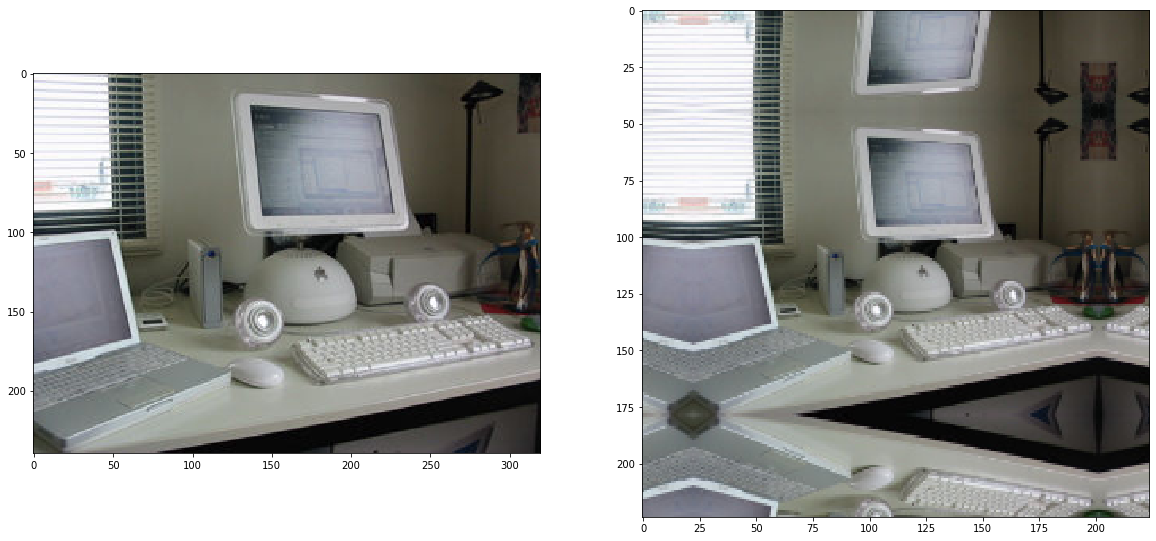

In [3]:
img1 = Image.open('/home/euloo/Documents/datasets/coco2017/val2017/000000001503.jpg') # маленькое изображение

img1 = np.float32(np.array(img1)) / 255.
aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
augmented = aug(image=img1)
img2 = augmented['image']


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

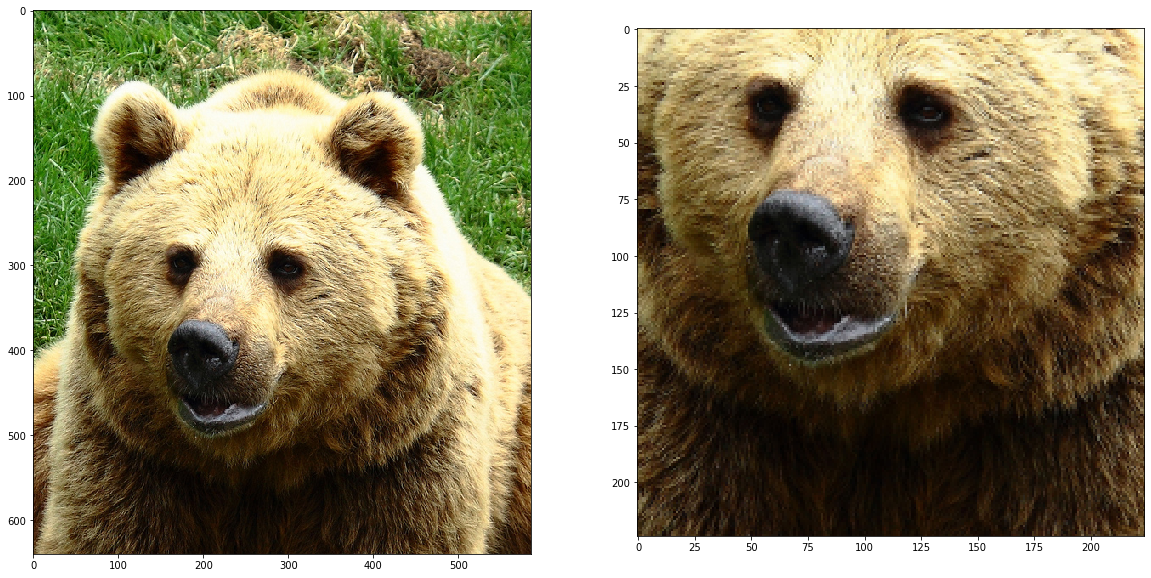

In [4]:
img1 = Image.open('/home/euloo/Documents/datasets/coco2017/val2017/000000000285.jpg') # большое изображение
img1 = np.float32(np.array(img1)) / 255.
aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
augmented = aug(image=img1)
img2 = augmented['image']


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

Реализация класса Dataset с чтением изображений и аннотаций в виде масок для тренировочного и валидационного датасетов.

In [5]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, subset='train', train_part=0.8):
        super().__init__(root, annFile, transforms=None, transform=None, target_transform=None)
        
        cat_names = ['bird',
                     'dog',
                     'sheep',
                     'elephant',
                     'zebra',
                     'giraffe',
                     'bear',
                     'cow',
                     'horse',
                     'cat'
                    ]
        
        cats = self.coco.loadCats(self.coco.getCatIds(cat_names))
        
        ids = []
        self.id_to_class, self.class_to_name = dict(), dict()
        self.id_to_class[0] = 0
        self.class_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.class_to_name[it+1] = cat['name']
            
            ids.append(self.coco.getImgIds(catIds=[cat['id']]))
        self.ids = sum(ids, [])
        np.random.seed(1)
        np.random.shuffle(self.ids)
        if subset == 'train':
            self.ids = self.ids[:int(len(self.ids) * train_part)]
        elif subset == 'valid':
            self.ids = self.ids[int(len(self.ids) * train_part):]
            
    def num_classes(self):
        return len(self.id_to_class)
    
        
    def __getitem__(self, index):

        img, ann = super().__getitem__(index)
        width, height = img.size[:2]

        msk = np.zeros((height, width), dtype=np.uint8)
        for i, it in enumerate(ann):
            if it['category_id'] in self.id_to_class.keys():
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                bw = mask.decode(compressed_rle)

                if len(bw.shape) == 3:
                    bw = np.sum(bw, axis=2)

                msk[np.where(bw != 0)] = self.id_to_class[it['category_id']]
        
        
        img = np.float32(np.array(img)) / 255.
        msk = np.array(msk)
        aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
        augmented = aug(image=img, mask=msk)
        img = augmented['image']
        msk = augmented['mask']
        

        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy())
        msk = torch.from_numpy(np.array(msk)).long()
              
        return img, msk, ann
    
    
    
    

Создаем объекты класса Dataset для тренировки и валидации.

In [6]:
path_to_images = '/home/euloo/Documents/datasets/coco2017/train2017'
#path_to_images = '/home/euloo/Documents/datasets/coco2017/val2017'
path_to_anno = '/home/euloo/Documents/datasets/coco2017/annotations/instances_train2017.json'
#path_to_anno = '/home/euloo/Documents/datasets/coco2017/annotations/instances_val2017.json'
train_dataset = Dataset(path_to_images, path_to_anno, subset='train')
valid_dataset = Dataset(path_to_images, path_to_anno, subset='valid')

loading annotations into memory...
Done (t=18.05s)
creating index...
index created!
loading annotations into memory...
Done (t=19.38s)
creating index...
index created!


In [7]:
train_dataset.class_to_name

{0: 'background',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'horse',
 5: 'sheep',
 6: 'cow',
 7: 'elephant',
 8: 'bear',
 9: 'zebra',
 10: 'giraffe'}

In [8]:
len(train_dataset), len(valid_dataset)

(20591, 5148)

Визуализируем результаты изображения и маски.

In [9]:
img, msk, ann = train_dataset[5]#5

In [10]:
for i in train_dataset.class_to_name:
    print(train_dataset.class_to_name[i], np.sum(msk.numpy() == i), ' pixels')

background 42798  pixels
bird 0  pixels
cat 7378  pixels
dog 0  pixels
horse 0  pixels
sheep 0  pixels
cow 0  pixels
elephant 0  pixels
bear 0  pixels
zebra 0  pixels
giraffe 0  pixels


/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


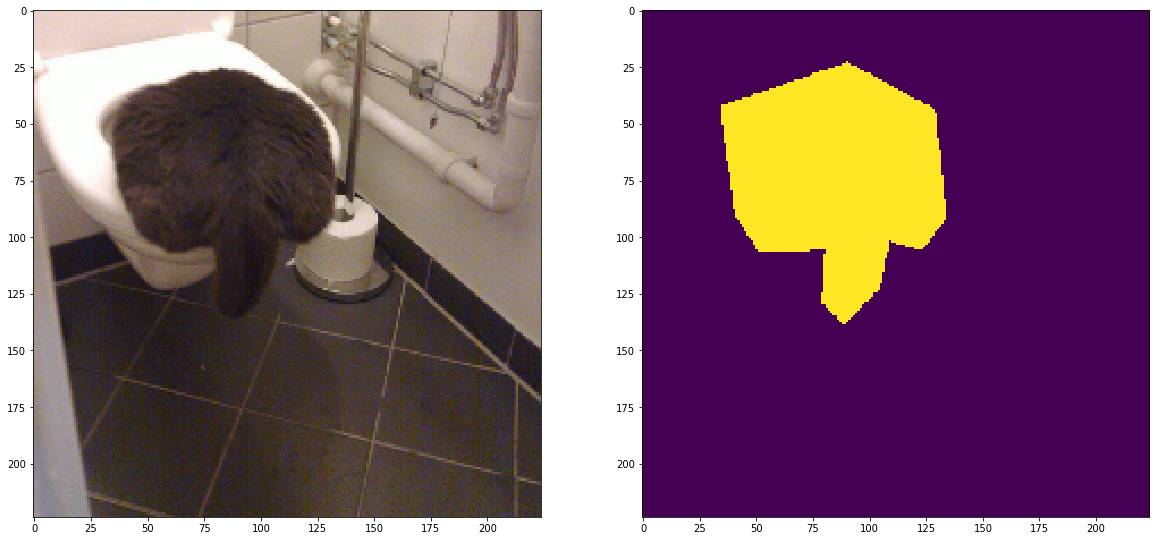

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img.numpy().transpose((1,2,0)))
plt.subplot(122)
plt.imshow(np.squeeze(msk.numpy()))
plt.show()

Создаем загрузчики данных для тренировки.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

Создаем класс для рассчета и хранения средних значений величин. Далее будем таким образом считать средние значения функции потерь и метрик.

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        #print("add val ", val, " weight " ,weight)
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

Создаем модели и определяем функцию потерь и метрики. Определяем шаги обучения.

In [14]:
from torch import nn

model = smp.FPN(encoder_name='resnet50', classes=train_dataset.num_classes(), activation='softmax').to(device)

print('===> Try resume from checkpoint')
if os.path.isdir('checkpoint'):
    try:
        checkpoint = torch.load('./checkpoint/model.t7')
        model.load_state_dict(checkpoint['state'])
        start_epoch = checkpoint['epoch']
        print('===> Load last checkpoint data')
    except FileNotFoundError:
        print('Can\'t found model.t7')
else:
    start_epoch = 0
    print('===> Start from scratch')

criterion = nn.CrossEntropyLoss()
criterion.__name__= 'loss'

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

===> Try resume from checkpoint
===> Start from scratch


- outputs = pred torch.Size([16, 11, 224, 224])
- masks = label torch.Size([16, 224, 224])
### TP TN FP FN 

In [15]:
# TP - пересечение предсказанного класса с действительным классом
def per_class_TP(preds, label):
    classes = []
    for i in train_dataset.class_to_name:
        pred_class = (preds == i).long()
        true_class = (label == i).long()
        TP = torch.sum(pred_class * true_class)
        classes.append(TP)
    return torch.stack(classes).float()

# TN - пересение предсказанных остальных классов (не этого класса) с действительными остальными классами.
def per_class_TN(preds, label): 
    classes = []
    for i in train_dataset.class_to_name:
        pred_not_class = (preds != i).long()
        not_true_class = (label != i).long()
        TN = torch.sum(pred_not_class * not_true_class)
        classes.append(TN)
    return torch.stack(classes).float()

# FP - пересение действительного класса с предсказанными остальными классами.
def per_class_FP(preds, label):
    classes = []
    for i in train_dataset.class_to_name:
        pred_class = (preds == i).long()
        not_true_class = (label != i).long()
        FP = torch.sum(pred_class * not_true_class)
        classes.append(FP)
    return torch.stack(classes).float()

# FN - пересечение действительного класса с предсказанными не классами. классами.
def per_class_FN(preds, label):
    classes = []
    for i in train_dataset.class_to_name:
        pred_not_class = (preds != i).long()
        true_class = (label == i).long()
        FN = torch.sum(pred_not_class * true_class)
        classes.append(FN)
    return torch.stack(classes).float()

In [16]:
def pixel_acc(pred, label):
    _, preds = torch.max(pred, dim=1)
    valid = (label >= 0).long()
    acc_sum = torch.sum(valid * (preds == label).long())
    pixel_sum = torch.sum(valid)
    acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
    return acc

In [17]:
def per_class_pixel_acc(pred, label):
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    TN = per_class_TN(preds, label)
    FP = per_class_FP(preds, label)
    FN = per_class_FN(preds, label)
    accuracy =(TP+TN)/(TP+TN+FP+FN+ 1e-10)
    return accuracy

def per_class_pixel_precision(pred, label):
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    FP = per_class_FP(preds, label)
    precision =TP/(TP+FP+ 1e-10)
    return precision

def per_class_pixel_recall(pred, label):
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    FN = per_class_FN(preds, label)
    recall =TP/(TP+FN+ 1e-10)
    return recall

def per_class_pixel_f1(pred, label):
    recall = per_class_pixel_recall(pred, label)
    precision = per_class_pixel_precision(pred, label)
    f1 = 2*precision*recall/(precision+recall+ 1e-10)
    return f1


### Обучение

In [18]:
from tqdm import trange, tqdm 

epochs = 10


for epoch in range(epochs): 
    average_total_loss = AverageMeter()
    average_total_val_loss = AverageMeter()
    
    average_acc = AverageMeter()
    average_val_acc = AverageMeter()
    
    average_acc_class = [AverageMeter() for i in range(11)]
    average_val_acc_class = [AverageMeter() for i in range(11)]
    
    average_precision_class = [AverageMeter() for i in range(11)]
    average_val_precision_class = [AverageMeter() for i in range(11)]
    
    average_recall_class = [AverageMeter() for i in range(11)]
    average_val_recall_class = [AverageMeter() for i in range(11)]
    
    average_f1_class = [AverageMeter() for i in range(11)]
    average_val_f1_class = [AverageMeter() for i in range(11)]
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} | {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} ', 
              postfix=[0, 'loss', 0, 'acc', 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)
            acc = pixel_acc(outputs, masks)
            
            acc_classes = per_class_pixel_acc(outputs, masks)
            precision_classes = per_class_pixel_precision(outputs, masks)
            recall_classes = per_class_pixel_recall(outputs, masks)
            f1_classes = per_class_pixel_f1(outputs, masks)
            
            #print(acc_classes)
            #print(precision_classes)

            loss.backward()
            optimizer.step()


            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            
            for i in range(11):
                average_acc_class[i].update(acc_classes[i])#()
                average_precision_class[i].update(precision_classes[i])
                average_recall_class[i].update(recall_classes[i])
                average_f1_class[i].update(f1_classes[i])
            
            t.postfix[2] = average_total_loss.average()
            t.postfix[4] = average_acc.average()
            
            avg_list = []# print it
            precision_list = []
            recall_list = []
            f1_list = []
            for i in range(11):
                avg_list.append(average_acc_class[i].average())
                precision_list.append(average_precision_class[i].average())
                recall_list.append(average_recall_class[i].average())
                f1_list.append(average_f1_class[i].average())
            #t.postfix[6] = avg_list
            t.update()
        
    #print(avg_list)
    print('                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe')
    print('per class acc           ', ["%0.2f" % i for i in avg_list])
    print('per class precision     ', ["%0.2f" % i for i in precision_list])
    print('per class recall        ', ["%0.2f" % i for i in recall_list])
    print('per class f1            ', ["%0.2f" % i for i in f1_list])
    #print(average_acc_class)
    
    # validation
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f}', 
              postfix=[0, 'val_loss', 0, 'val_acc', 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, masks) 
            acc = pixel_acc(outputs, masks)
            acc_classes = per_class_pixel_acc(outputs, masks)
            precision_classes = per_class_pixel_precision(outputs, masks)
            recall_classes = per_class_pixel_recall(outputs, masks)
            f1_classes = per_class_pixel_f1(outputs, masks)
            
            

            average_total_val_loss.update(loss.data.item())
            average_val_acc.update(acc.data.item())
            for i in range(11):
                average_val_acc_class[i].update(acc_classes[i])#()
                average_val_precision_class[i].update(precision_classes[i])
                average_val_recall_class[i].update(recall_classes[i])
                average_val_f1_class[i].update(f1_classes[i])
            #average_val_acc_class
            
            t.postfix[2] = average_total_val_loss.average()
            t.postfix[4] = average_val_acc.average()
            
            avg_list = []# print it
            precision_list = []
            recall_list = []
            f1_list = []
            for i in range(11):
                avg_list.append(average_val_acc_class[i].average())
                precision_list.append(average_val_precision_class[i].average())
                recall_list.append(average_val_recall_class[i].average())
                f1_list.append(average_val_f1_class[i].average())
            t.update()
    print('                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe')
    print('per class val acc       ', ["%0.2f" % i for i in avg_list])
    print('per class val precision ', ["%0.2f" % i for i in precision_list])
    print('per class val recall    ', ["%0.2f" % i for i in recall_list])
    print('per class val f1        ', ["%0.2f" % i for i in f1_list])
    print('                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒')
    
    if epoch % 2 == 0:
        print('===> Saving models...')
        state = {
            'state': model.state_dict(),
            'epoch': epoch
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/model.t7')   

Training epoch 1 | 1287/1287 06:39<00:00 | loss : 0.3978 | acc : 0.8892 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.91', '0.99', '0.98', '0.98', '0.98', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99']
per class precision      ['0.93', '0.42', '0.66', '0.56', '0.51', '0.38', '0.39', '0.58', '0.32', '0.59', '0.62']
per class recall         ['0.96', '0.33', '0.66', '0.52', '0.44', '0.30', '0.31', '0.55', '0.28', '0.57', '0.57']
per class f1             ['0.94', '0.33', '0.63', '0.50', '0.43', '0.30', '0.31', '0.55', '0.28', '0.56', '0.57']


Validation epoch 1 322/322 00:56<00:00 | val_loss : 0.1986 | val_acc : 0.9338
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.94', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '1.00', '1.00', '0.99']
per class val precision  ['0.96', '0.58', '0.79', '0.69', '0.68', '0.49', '0.49', '0.65', '0.39', '0.65', '0.65']
per class val recall     ['0.97', '0.40', '0.75', '0.67', '0.44', '0.41', '0.52', '0.56', '0.35', '0.59', '0.68']
per class val f1         ['0.96', '0.45', '0.76', '0.66', '0.51', '0.42', '0.49', '0.58', '0.35', '0.61', '0.66']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒
===> Saving models...


Training epoch 2 | 1287/1287 06:36<00:00 | loss : 0.2213 | acc : 0.9290 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.94', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '1.00', '1.00', '0.99']
per class precision      ['0.96', '0.53', '0.75', '0.67', '0.61', '0.47', '0.52', '0.66', '0.37', '0.65', '0.70']
per class recall         ['0.97', '0.43', '0.75', '0.63', '0.56', '0.40', '0.44', '0.63', '0.34', '0.64', '0.67']
per class f1             ['0.96', '0.44', '0.74', '0.63', '0.56', '0.40', '0.45', '0.63', '0.34', '0.64', '0.67']


Validation epoch 2 322/322 00:55<00:00 | val_loss : 0.1768 | val_acc : 0.9397
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.95', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '1.00', '1.00', '0.99']
per class val precision  ['0.97', '0.55', '0.78', '0.71', '0.66', '0.44', '0.56', '0.64', '0.39', '0.65', '0.67']
per class val recall     ['0.97', '0.52', '0.78', '0.64', '0.51', '0.45', '0.50', '0.62', '0.34', '0.61', '0.77']
per class val f1         ['0.97', '0.51', '0.77', '0.65', '0.55', '0.43', '0.51', '0.61', '0.35', '0.62', '0.71']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒


Training epoch 3 | 1287/1287 06:36<00:00 | loss : 0.1859 | acc : 0.9377 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.95', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '1.00', '1.00', '0.99']
per class precision      ['0.96', '0.55', '0.77', '0.73', '0.63', '0.49', '0.54', '0.67', '0.39', '0.66', '0.72']
per class recall         ['0.97', '0.44', '0.76', '0.69', '0.59', '0.44', '0.49', '0.66', '0.36', '0.65', '0.70']
per class f1             ['0.97', '0.46', '0.75', '0.68', '0.58', '0.44', '0.49', '0.66', '0.36', '0.64', '0.70']


Validation epoch 3 322/322 00:56<00:00 | val_loss : 0.1639 | val_acc : 0.9439
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.95', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '0.99', '1.00', '1.00', '0.99']
per class val precision  ['0.96', '0.56', '0.82', '0.73', '0.70', '0.50', '0.58', '0.67', '0.39', '0.61', '0.73']
per class val recall     ['0.97', '0.47', '0.79', '0.67', '0.52', '0.47', '0.50', '0.68', '0.35', '0.64', '0.72']
per class val f1         ['0.97', '0.49', '0.79', '0.68', '0.57', '0.46', '0.51', '0.67', '0.36', '0.62', '0.71']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒
===> Saving models...


Training epoch 4 | 1287/1287 06:36<00:00 | loss : 0.1648 | acc : 0.9435 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.95', '1.00', '0.99', '0.99', '0.99', '0.99', '0.99', '0.99', '1.00', '1.00', '0.99']
per class precision      ['0.96', '0.57', '0.80', '0.74', '0.64', '0.50', '0.57', '0.68', '0.40', '0.64', '0.73']
per class recall         ['0.97', '0.47', '0.79', '0.70', '0.61', '0.45', '0.52', '0.67', '0.38', '0.64', '0.71']
per class f1             ['0.97', '0.48', '0.78', '0.70', '0.60', '0.45', '0.52', '0.66', '0.38', '0.63', '0.72']


Validation epoch 4 322/322 00:55<00:00 | val_loss : 0.1539 | val_acc : 0.9474
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.95', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '0.99', '1.00', '1.00', '1.00']
per class val precision  ['0.96', '0.60', '0.81', '0.75', '0.68', '0.50', '0.60', '0.65', '0.42', '0.64', '0.76']
per class val recall     ['0.98', '0.41', '0.79', '0.65', '0.61', '0.42', '0.51', '0.61', '0.41', '0.64', '0.72']
per class val f1         ['0.97', '0.47', '0.79', '0.67', '0.62', '0.44', '0.53', '0.61', '0.40', '0.64', '0.73']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒


Training epoch 5 | 1287/1287 06:36<00:00 | loss : 0.1512 | acc : 0.9473 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.95', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '0.99', '1.00', '1.00', '0.99']
per class precision      ['0.97', '0.59', '0.81', '0.77', '0.67', '0.51', '0.59', '0.69', '0.39', '0.65', '0.73']
per class recall         ['0.97', '0.49', '0.79', '0.72', '0.64', '0.46', '0.55', '0.67', '0.37', '0.65', '0.72']
per class f1             ['0.97', '0.51', '0.79', '0.73', '0.63', '0.47', '0.54', '0.67', '0.37', '0.65', '0.72']


Validation epoch 5 322/322 00:55<00:00 | val_loss : 0.1489 | val_acc : 0.9483
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.97', '0.61', '0.81', '0.75', '0.67', '0.47', '0.57', '0.63', '0.38', '0.65', '0.77']
per class val recall     ['0.97', '0.43', '0.81', '0.65', '0.63', '0.48', '0.57', '0.63', '0.39', '0.66', '0.78']
per class val f1         ['0.97', '0.49', '0.80', '0.68', '0.63', '0.46', '0.54', '0.62', '0.38', '0.66', '0.77']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒
===> Saving models...


Training epoch 6 | 1287/1287 06:36<00:00 | loss : 0.1393 | acc : 0.9506 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '0.99', '1.00', '1.00', '1.00']
per class precision      ['0.97', '0.59', '0.82', '0.78', '0.68', '0.51', '0.58', '0.68', '0.40', '0.67', '0.75']
per class recall         ['0.98', '0.49', '0.79', '0.74', '0.65', '0.48', '0.54', '0.67', '0.38', '0.66', '0.73']
per class f1             ['0.97', '0.51', '0.80', '0.74', '0.65', '0.48', '0.54', '0.67', '0.38', '0.66', '0.74']


Validation epoch 6 322/322 00:56<00:00 | val_loss : 0.1477 | val_acc : 0.9501
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.97', '0.62', '0.83', '0.74', '0.70', '0.52', '0.55', '0.67', '0.37', '0.70', '0.72']
per class val recall     ['0.98', '0.49', '0.78', '0.73', '0.61', '0.51', '0.60', '0.62', '0.37', '0.66', '0.78']
per class val f1         ['0.97', '0.52', '0.79', '0.71', '0.63', '0.50', '0.56', '0.63', '0.36', '0.67', '0.75']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒


Training epoch 7 | 1287/1287 06:36<00:00 | loss : 0.1308 | acc : 0.9531 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '0.99', '1.00', '1.00', '1.00']
per class precision      ['0.97', '0.60', '0.82', '0.79', '0.68', '0.52', '0.60', '0.70', '0.41', '0.67', '0.74']
per class recall         ['0.98', '0.51', '0.80', '0.74', '0.65', '0.48', '0.56', '0.69', '0.39', '0.67', '0.73']
per class f1             ['0.97', '0.53', '0.80', '0.75', '0.65', '0.48', '0.56', '0.69', '0.40', '0.67', '0.73']


Validation epoch 7 322/322 00:53<00:00 | val_loss : 0.1431 | val_acc : 0.9507
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.97', '0.59', '0.84', '0.73', '0.65', '0.50', '0.61', '0.64', '0.40', '0.65', '0.78']
per class val recall     ['0.98', '0.45', '0.82', '0.70', '0.64', '0.41', '0.57', '0.65', '0.42', '0.66', '0.75']
per class val f1         ['0.97', '0.49', '0.82', '0.69', '0.63', '0.43', '0.56', '0.64', '0.40', '0.65', '0.76']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒
===> Saving models...


Training epoch 8 | 1287/1287 06:35<00:00 | loss : 0.1260 | acc : 0.9548 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
per class precision      ['0.97', '0.63', '0.84', '0.79', '0.69', '0.53', '0.61', '0.71', '0.41', '0.67', '0.75']
per class recall         ['0.98', '0.52', '0.82', '0.75', '0.67', '0.49', '0.58', '0.70', '0.39', '0.66', '0.74']
per class f1             ['0.97', '0.55', '0.82', '0.76', '0.67', '0.50', '0.57', '0.70', '0.39', '0.66', '0.74']


Validation epoch 8 322/322 00:52<00:00 | val_loss : 0.1448 | val_acc : 0.9510
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.96', '0.63', '0.85', '0.78', '0.72', '0.51', '0.59', '0.65', '0.39', '0.64', '0.77']
per class val recall     ['0.98', '0.45', '0.76', '0.70', '0.60', '0.47', '0.50', '0.64', '0.39', '0.67', '0.74']
per class val f1         ['0.97', '0.50', '0.79', '0.71', '0.64', '0.47', '0.51', '0.63', '0.38', '0.65', '0.75']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒


Training epoch 9 | 1287/1287 06:41<00:00 | loss : 0.1191 | acc : 0.9568 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
per class precision      ['0.97', '0.62', '0.84', '0.79', '0.69', '0.53', '0.61', '0.71', '0.41', '0.67', '0.74']
per class recall         ['0.98', '0.53', '0.82', '0.75', '0.67', '0.50', '0.58', '0.70', '0.39', '0.67', '0.74']
per class f1             ['0.97', '0.55', '0.82', '0.76', '0.67', '0.50', '0.58', '0.70', '0.39', '0.66', '0.74']


Validation epoch 9 322/322 00:52<00:00 | val_loss : 0.1392 | val_acc : 0.9528
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.97', '0.63', '0.85', '0.72', '0.70', '0.48', '0.56', '0.66', '0.39', '0.67', '0.76']
per class val recall     ['0.98', '0.52', '0.79', '0.76', '0.63', '0.46', '0.53', '0.67', '0.39', '0.67', '0.72']
per class val f1         ['0.97', '0.54', '0.81', '0.72', '0.65', '0.45', '0.53', '0.66', '0.38', '0.66', '0.74']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒
===> Saving models...


Training epoch 10 | 1287/1287 06:40<00:00 | loss : 0.1162 | acc : 0.9575 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class acc            ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
per class precision      ['0.97', '0.64', '0.84', '0.79', '0.70', '0.54', '0.61', '0.70', '0.42', '0.68', '0.75']
per class recall         ['0.98', '0.54', '0.82', '0.76', '0.67', '0.50', '0.58', '0.69', '0.40', '0.68', '0.74']
per class f1             ['0.97', '0.56', '0.82', '0.76', '0.67', '0.50', '0.58', '0.69', '0.40', '0.68', '0.74']


Validation epoch 10 322/322 00:55<00:00 | val_loss : 0.1400 | val_acc : 0.9528

                           back   |bird   |cat    |dog    |horse  |sheep  |cow    |elephan|bear   |zebra  |giraffe
per class val acc        ['0.96', '1.00', '0.99', '0.99', '0.99', '1.00', '0.99', '1.00', '1.00', '1.00', '1.00']
per class val precision  ['0.97', '0.64', '0.85', '0.74', '0.69', '0.53', '0.58', '0.66', '0.40', '0.67', '0.73']
per class val recall     ['0.98', '0.51', '0.78', '0.73', '0.68', '0.49', '0.55', '0.67', '0.37', '0.67', '0.73']
per class val f1         ['0.97', '0.55', '0.80', '0.71', '0.67', '0.49', '0.55', '0.66', '0.37', '0.66', '0.72']
                             ⬛️       🦜️       😺     🐶       🦄       🐑      🐮       🐘     🐻       🦓       🦒


In [19]:
print('===> Saving models...')
state = {'state': model.state_dict(),
         'epoch': epoch
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
    torch.save(state, './checkpoint/model.t7')   

===> Saving models...


In [20]:
!nvidia-smi

Fri Nov 15 20:26:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:22:00.0  On |                  N/A |
| 51%   64C    P2    34W / 180W |   5470MiB /  8112MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Визуальная оценка результатов
Все классы выглядят неплохо, если объект крупный. 

In [21]:
def plot_val(i):
    img, msk, _ = valid_dataset[i]
    sm = nn.Softmax(dim=1)
    pred = sm(model(img.expand(1, -1,-1,-1).to(device)))
    _, max_pred = torch.max(pred, dim=1)
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.subplot(132)
    plt.imshow(np.squeeze(msk.numpy()))
    plt.subplot(133)
    plt.imshow(max_pred[0].detach().cpu().numpy())

# bird   

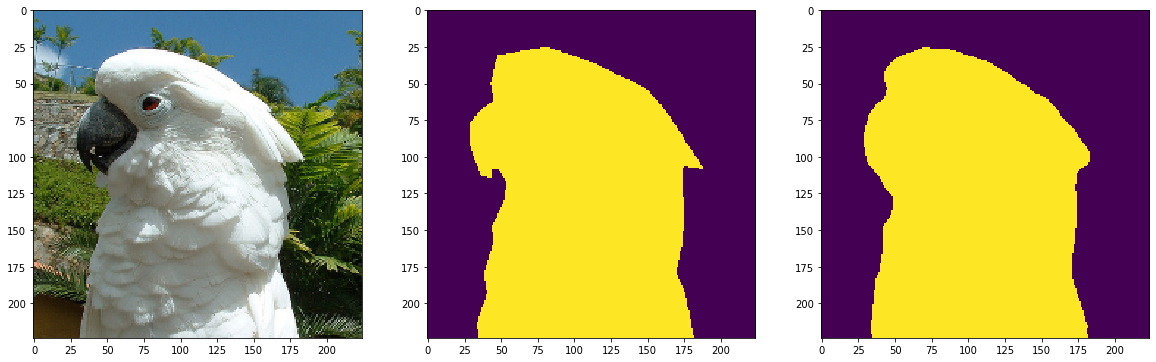

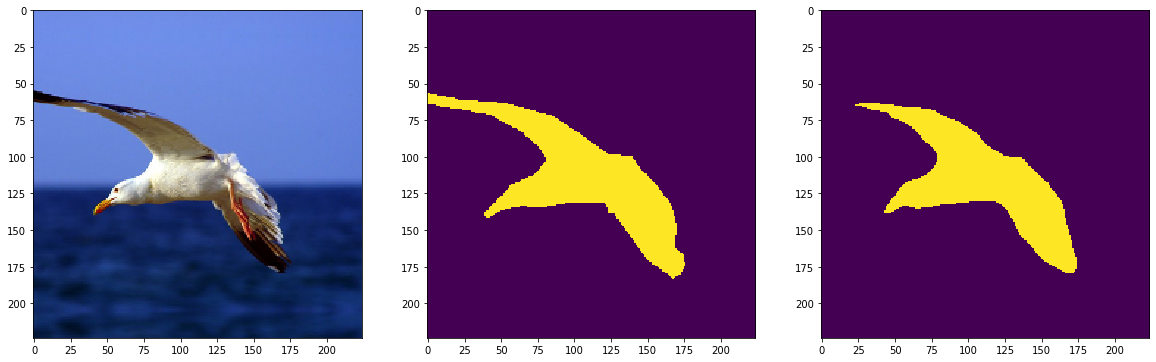

In [24]:
plot_val(555)
plot_val(47)

# cat     

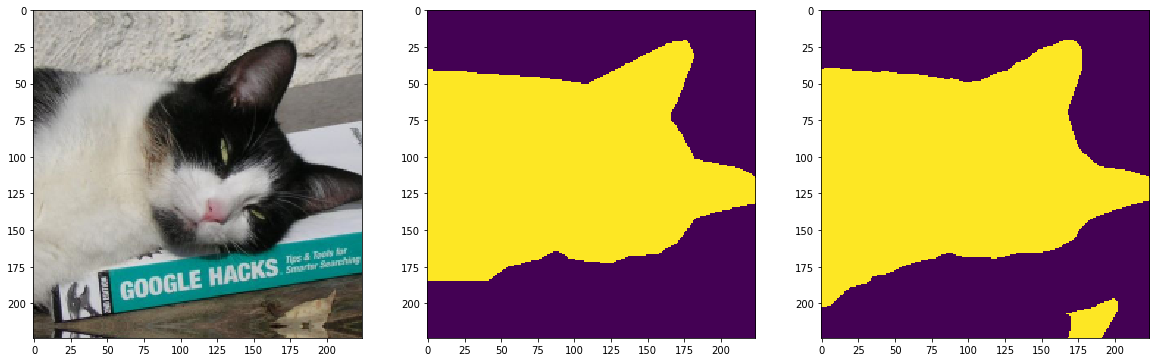

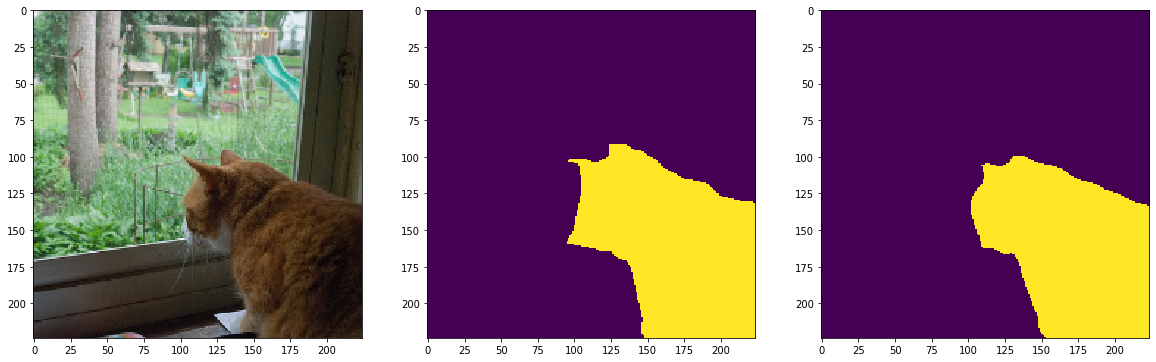

In [25]:
plot_val(8)
plot_val(82)

# dog    

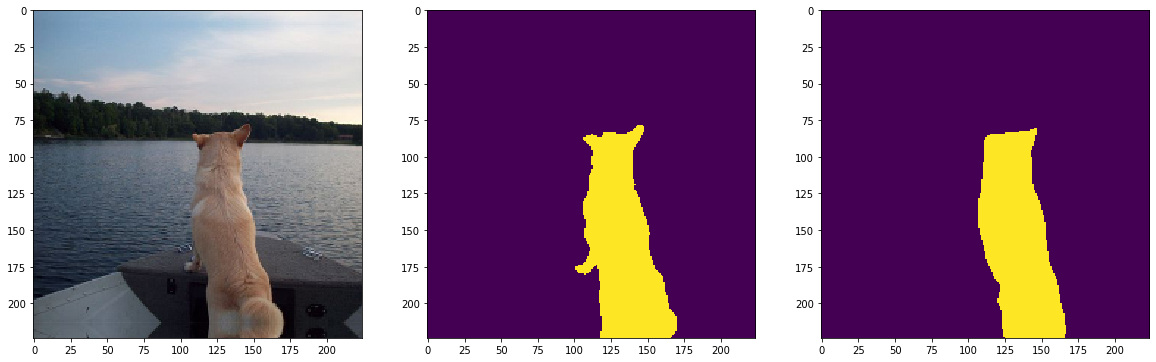

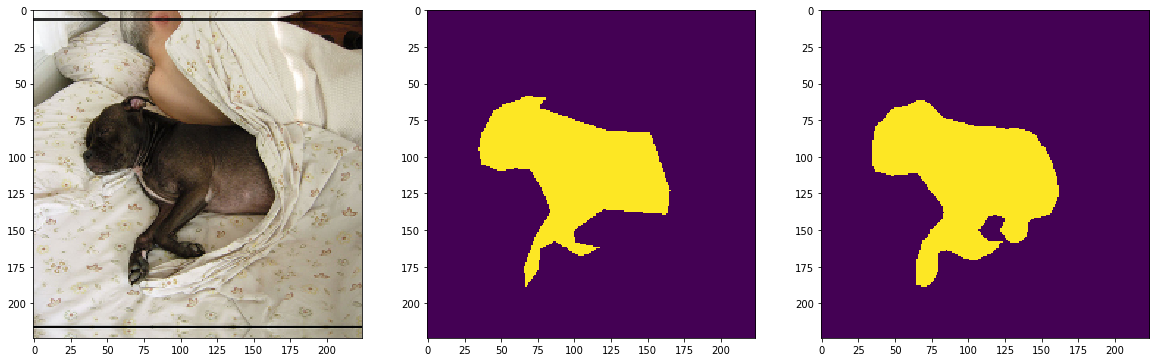

In [26]:
plot_val(15)
plot_val(2)

# horse   

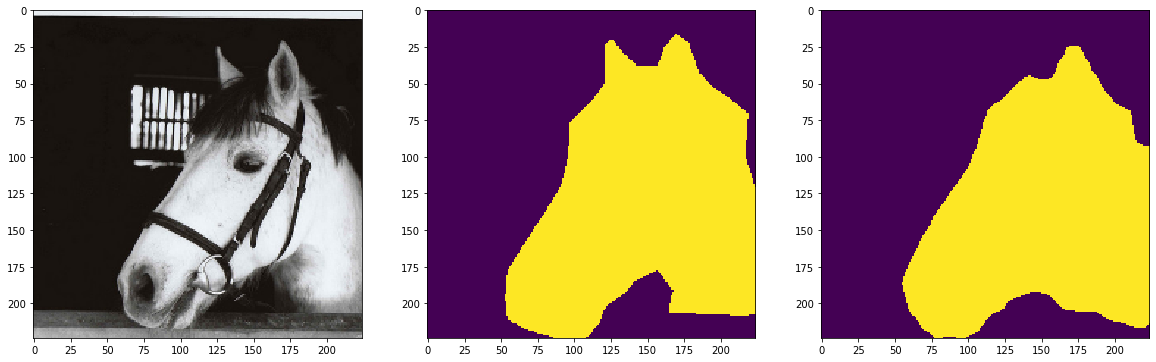

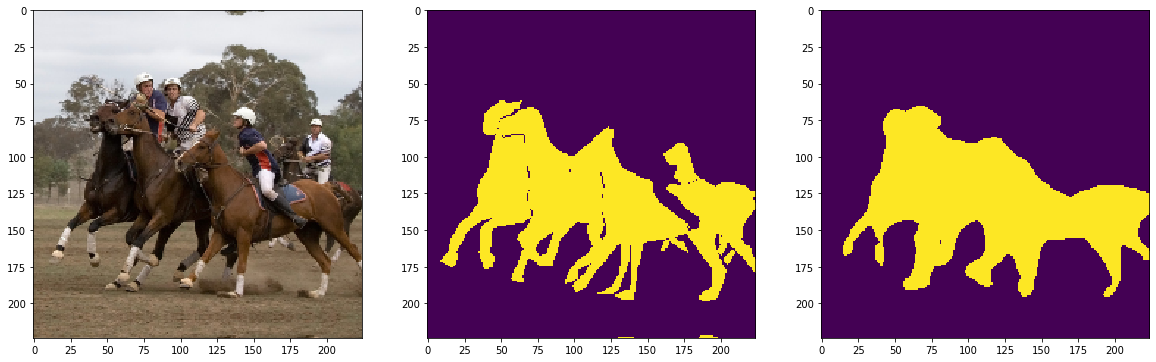

In [28]:
plot_val(17)
plot_val(11)

# sheep   

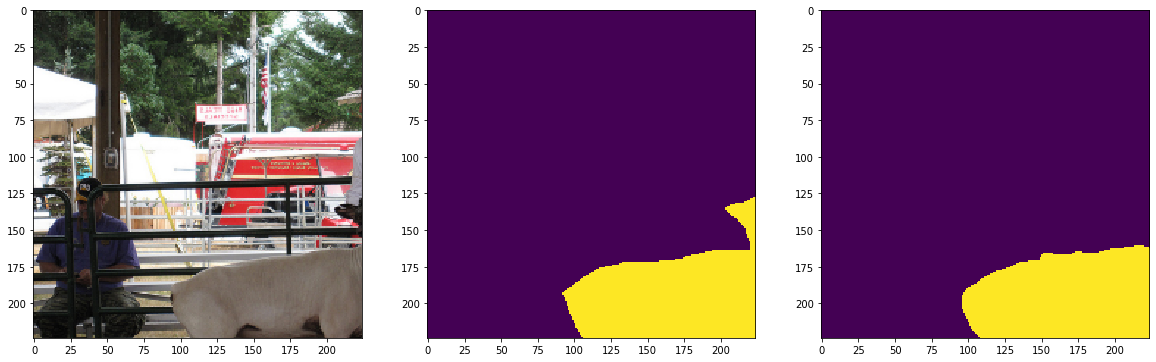

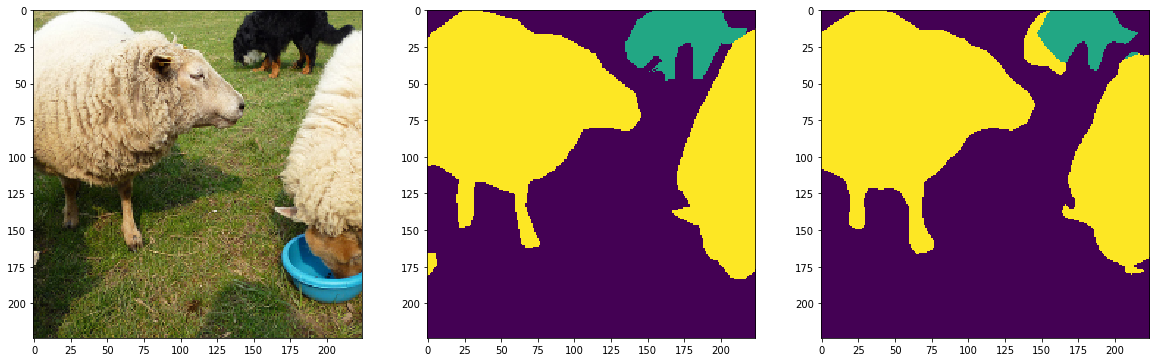

In [49]:
plot_val(4)
plot_val(81)

# cow     

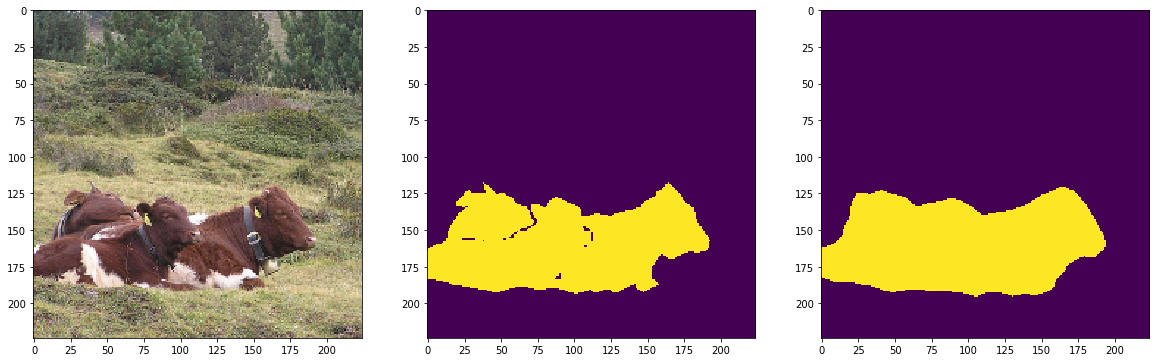

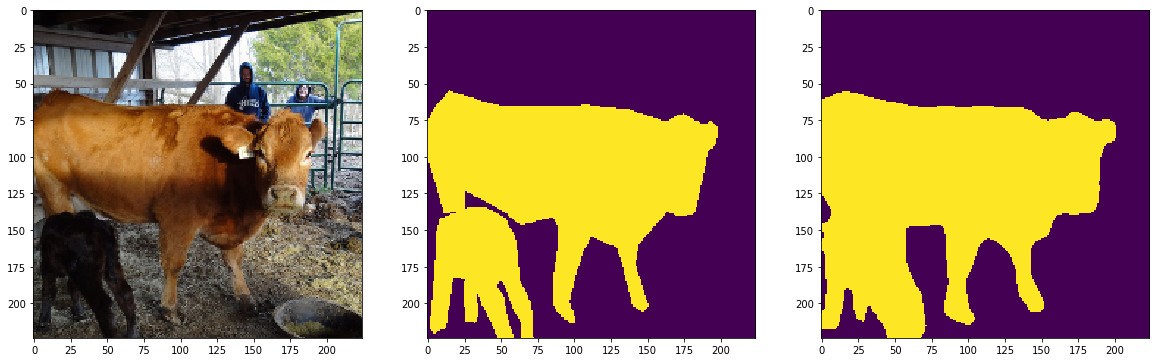

In [50]:
plot_val(75)
plot_val(88)

# elephant

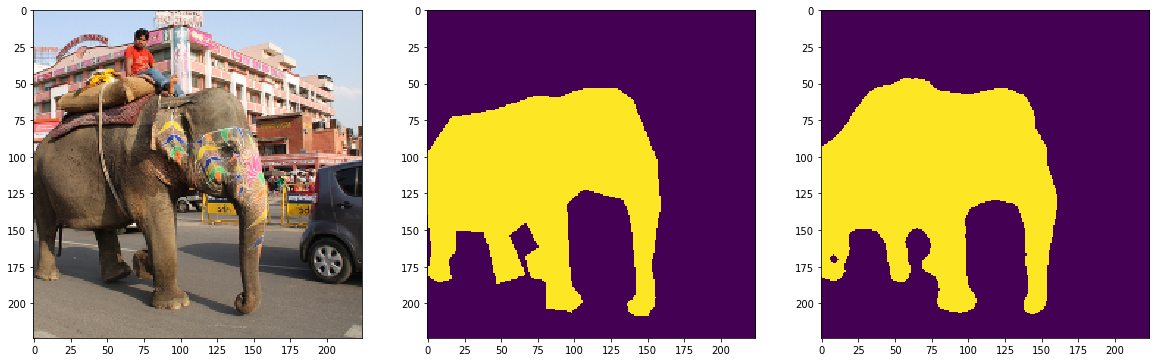

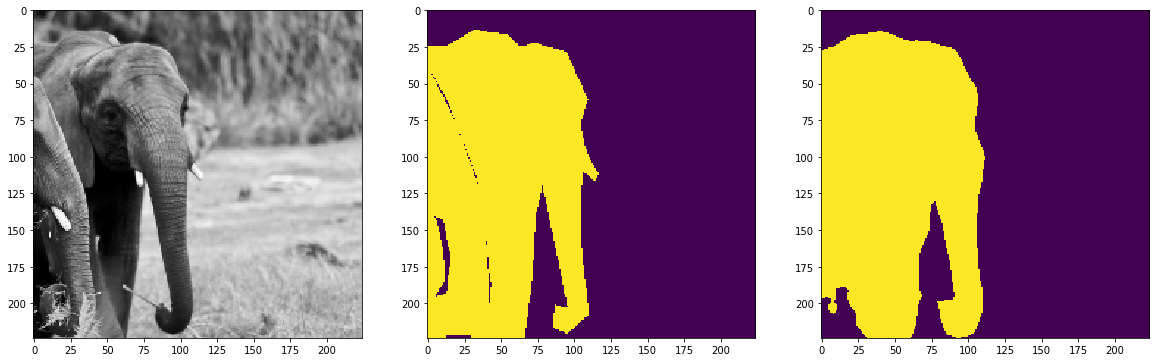

In [51]:
plot_val(19)
plot_val(24)

# bear    

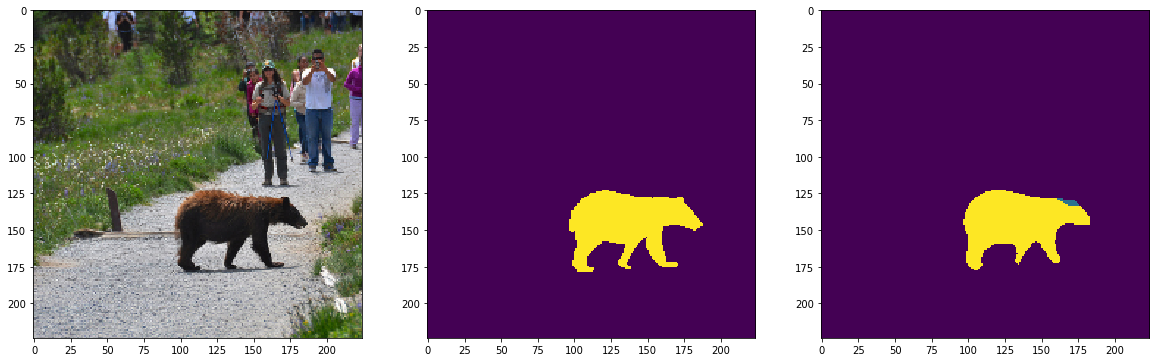

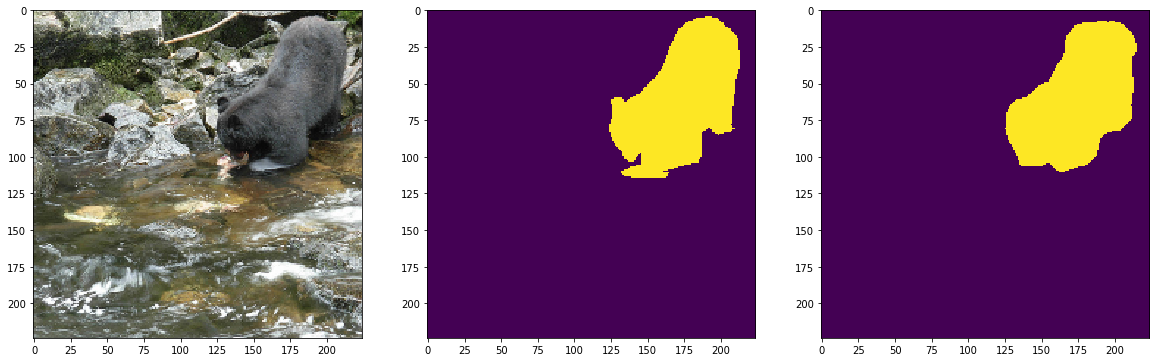

In [54]:
plot_val(13)
plot_val(60)

# zebra   

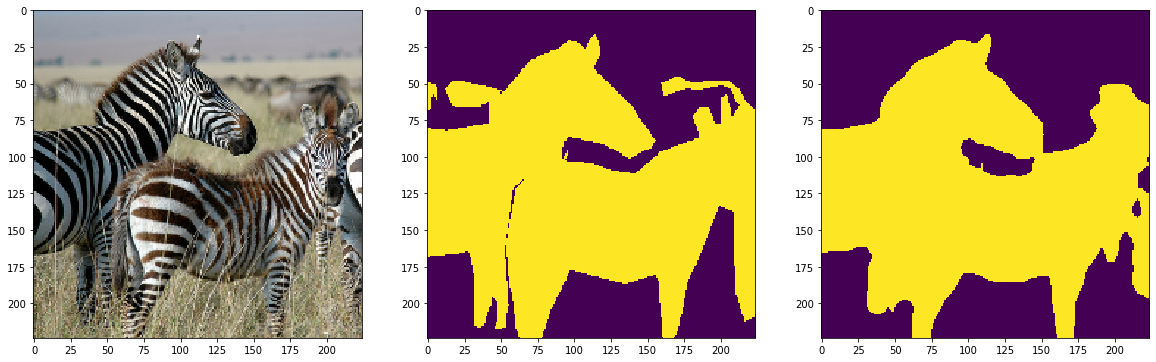

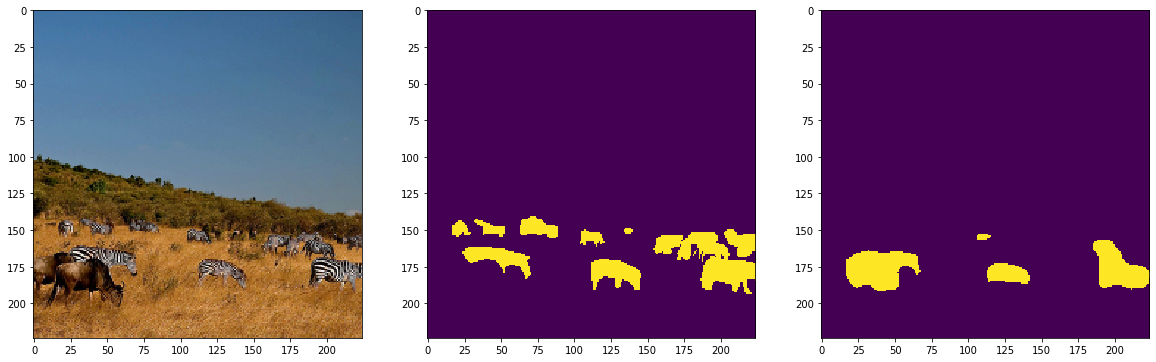

In [56]:
plot_val(30)
plot_val(33)

# giraffe

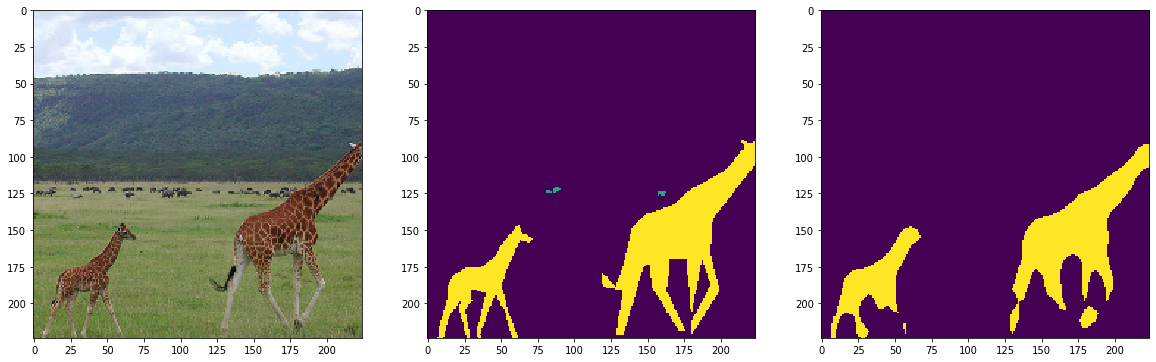

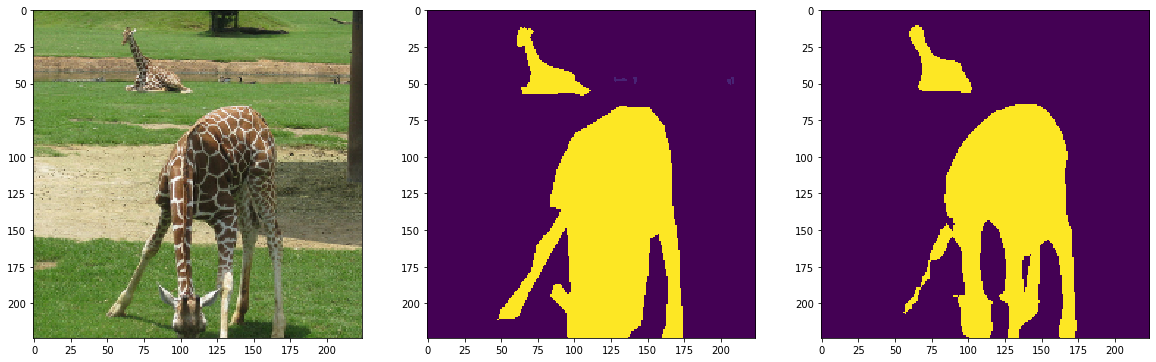

In [57]:
plot_val(5)
plot_val(9)

# Слишком сложное

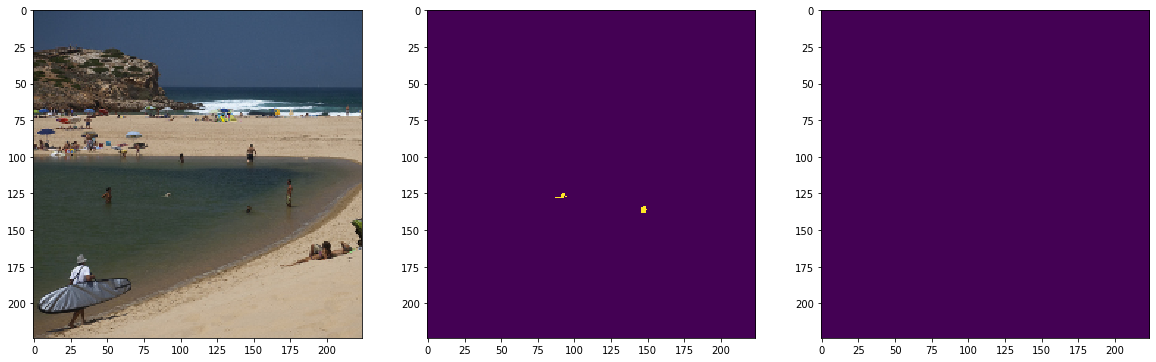

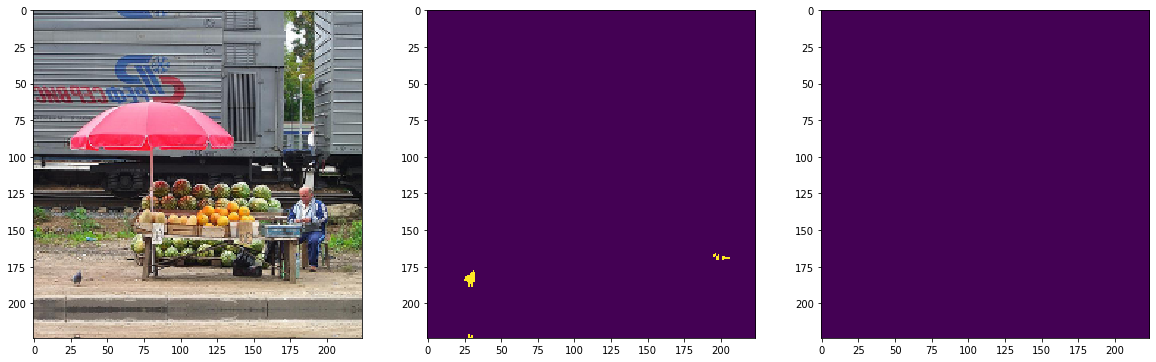

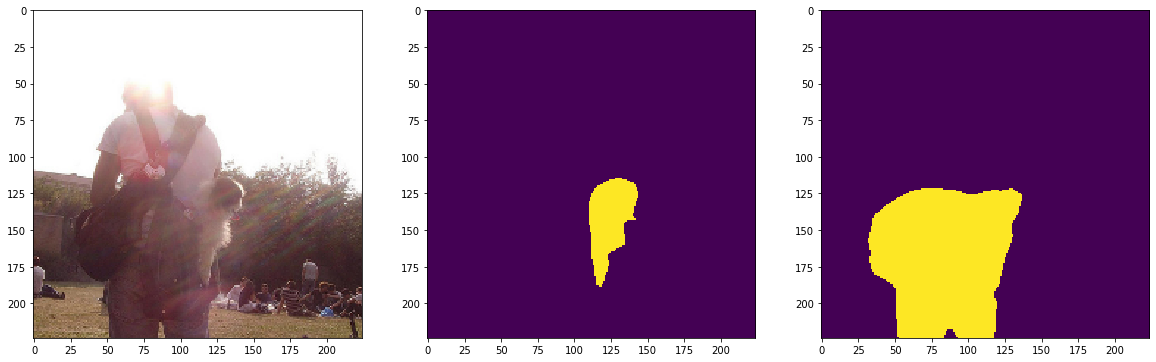

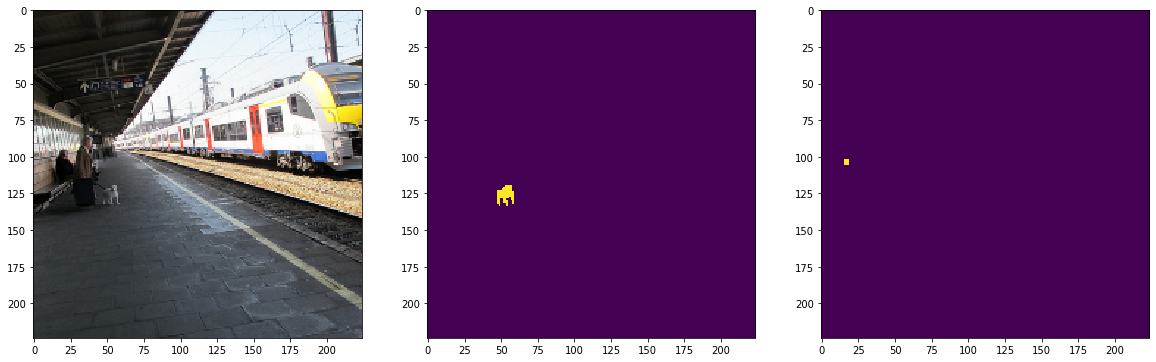

In [58]:
plot_val(41)
plot_val(42)
plot_val(74)
plot_val(98)

# Несколько классов

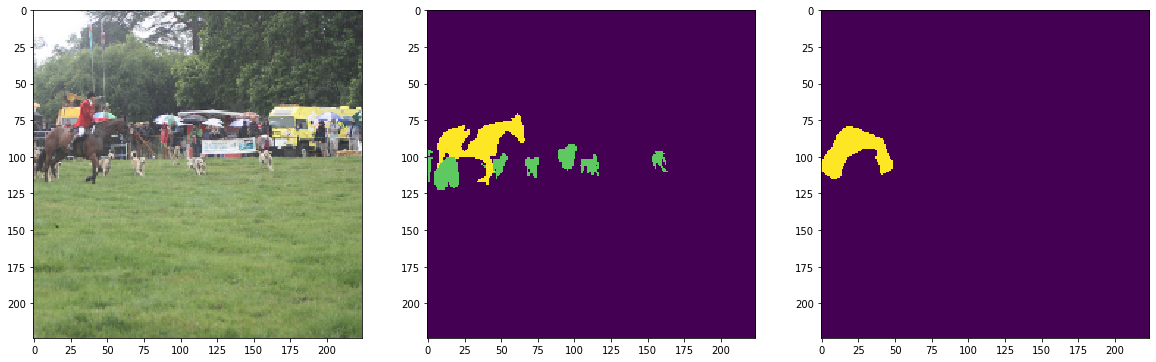

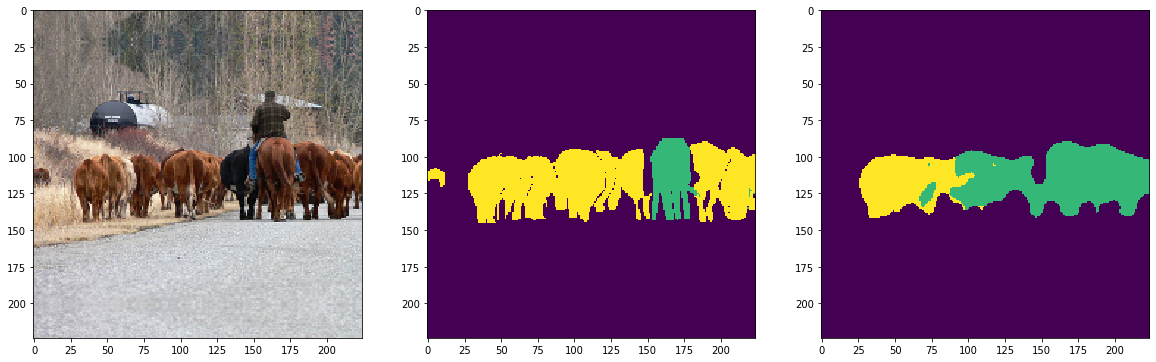

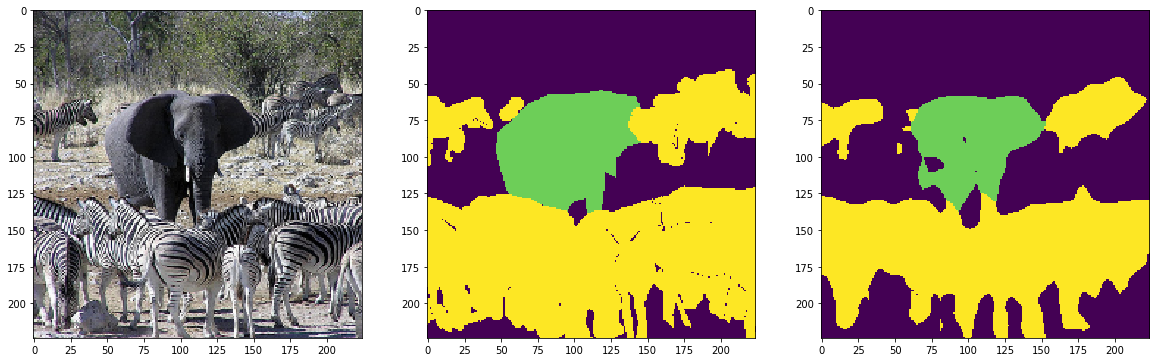

In [68]:
plot_val(57)
plot_val(12)
plot_val(70)